## Assignment 1: Word Embedding

In this assignment , we have to
* Download the IMDB dataset
* Tokenize the records and create train and validation datasets
* Download the Glove pretrained Word Embedding
* Define a model which uses Glove pretrained Word Embedding
* Train the model on IMDB dataset



## Processing the labels of the raw IMDB data

* Manually download IMDB Dataset from URL as a zip file to a folder E:\\eva\\phase2_assignment1
* Unzip the IMDB dataset
* Process the files in  train/neg folder by reading the text and label them as 0 
* Process the files in  train/pos folder by reading the text and label them as 1 


In [1]:
import os
imdb_dir = 'E:\\eva\\phase2_assignment1'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),  encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [2]:
texts[0:5]

["Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.",
 "This is an example of why the majority of action films are the same. Generic and boring, ther

In [3]:
labels[0:5]

[0, 0, 0, 0, 0]

## Tokenize the text of the raw IMDB data and create train and validation datasets

* Process list of text by tokenizing and creating a sequence of words
* Pad the sequence of words so that maxlength is 100
* Randomly shuffle the indices
* Create train dataset x_train,y_train 
* Create validation dataset x_val,y_val



In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


maxlen = 100
training_samples = 8000
validation_samples = 10000
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 72633 unique tokens.
Shape of data tensor: (17243, 100)
Shape of label tensor: (17243,)


## Download and Preprocess Glove word embedding
* Download Glove word embedding from https://nlp.stanford.edu/projects/glove to folder E:\\eva\\phase2_assignment1 and unzip it
* Create a map embeddings_index with key as word and value as embedding vector 

In [5]:
glove_dir = 'E:\\eva\\phase2_assignment1'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Populate the embedding matrix
* Create a matrix embedding_matrix of dimension max words x embedding dimension and initialize to 0
* Populate the matrix by iterating over words in embedding_index where each entry i contains the embedding_dim-dimensional vector for the word of index i in the reference word index

In [6]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Define Keras Model

The model has
* Embedding Input Layer
* Flatten the embedding
* Add Dense layer of size 128 with activation relu
* Add Dropout 
* Add Dense lyaer of size 32 with activation relu
* Add Dense layer of size 1 and activation sigmoid

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,284,289
Trainable params: 2,284,289
Non-trainable params: 0
____________________________________________

## Freeze the embedding layer

In [8]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## Compile and Train the model
* Compile the model with optimize RMSProp, loss as binary cross entropy and metrics is accuracy
* Train the model by calling fit function and passing train and validation datasets


In [9]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=64,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 8000 samples, validate on 9243 samples
Epoch 1/10
8000/8000 [==============================] - 4s 506us/step - loss: 0.7381 - acc: 0.6911 - val_loss: 0.5357 - val_acc: 0.7372
Epoch 2/10
8000/8000 [==============================] - 1s 123us/step - loss: 0.5402 - acc: 0.7446 - val_loss: 0.5157 - val_acc: 0.7599
Epoch 3/10
8000/8000 [==============================] - 1s 109us/step - loss: 0.4736 - acc: 0.7855 - val_loss: 0.5497 - val_acc: 0.7486
Epoch 4/10
8000/8000 [==============================] - 1s 115us/step - loss: 0.4240 - acc: 0.8131 - val_loss: 0.5128 - val_acc: 0.7432
Epoch 5/10
8000/8000 [==============================] - 1s 115us/step - loss: 0.3583 - acc: 0.8450 - val_loss: 0.5109 - val_acc: 0.7698
Epoch 6/10
8000/8000 [==============================] - 1s 125us/step - loss: 0.3156 - acc: 0.8648 - val_loss: 0.6290 - val_acc: 0.6852
Epoch 7/10
8000/8000 [==============================] - 1s 117us/step - loss: 0.2570 - acc: 0.8914 - val_loss: 1.0816 - val_acc: 0.5439


## Plot the training and validation results

* Create a plot of training loss and accuracy
* Create a plot of validation loss and accuracy

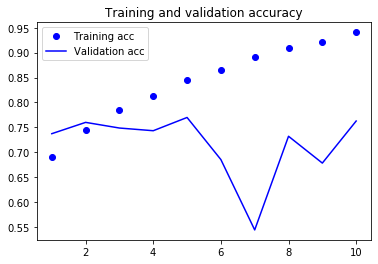

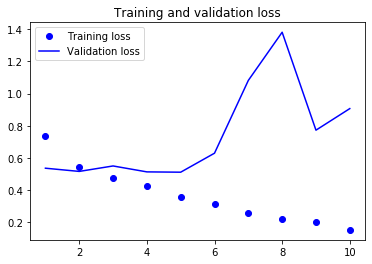

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('train_validation_graph.png')
plt.show()

## Final Observation:

In this assignment we have used Glove Embedding and train on the IMDB dataset and got a best validation accuracy of 76.98